## This notebook is for testing the SDK before using any scripts for data retrieval / live feed
- Make sure you have the .env file with the corrent variable names listed below before running the code

In [3]:
# Authentication for streaming data
from neurosity import NeurositySDK
from dotenv import load_dotenv
import os

load_dotenv()

neurosity = NeurositySDK({
    "device_id": os.getenv("NEUROSITY_DEVICE_ID")
})

neurosity.login({
    "email": os.getenv("NEUROSITY_EMAIL"),
    "password": os.getenv("NEUROSITY_PASSWORD")
})

ModuleNotFoundError: No module named 'neurosity'

In [5]:
# checking the info from the SDK
info = neurosity.get_info()
print(info)

OrderedDict({'channelNames': ['CP6', 'F6', 'C4', 'CP4', 'CP3', 'F5', 'C3', 'CP5'], 'channels': 8, 'deviceId': 'e425ea92bcd7bdae65a5c2b07322433d', 'deviceNickname': 'Emulator-E42', 'emulator': True, 'manufacturer': 'Neurosity, Inc', 'model': 'Emulator 2', 'modelName': 'Emulator', 'modelVersion': '2', 'osVersion': '14.5.0', 'samplingRate': 250})


# Raw Brainwaves Data

In [6]:
# Retrieving raw brainwaves and storing 1 epoch
import time
sample = 0

def callback(data):
    global sample
    sample = data
    
unsubscribe = neurosity.brainwaves_raw(callback) # the function returned from calling the api is used to stop the data feed

time.sleep(1)

unsubscribe()

In [7]:
import matplotlib.pyplot as plt
import numpy as np
# What one epoch looks like
# print(sample)

# Storing & Visualizing 
channels = ['CP6', 'F6', 'C4', 'CP4', 'CP3', 'F5', 'C3', 'CP5']
data = np.array(sample['data'])  
print(data)
print(data.shape)
print(sample['info'])

[[-8.94957145e+00 -5.21284504e+00  1.56958250e-01  4.07906667e+00
   4.49568552e+00  3.85197864e+00  4.22258614e+00  6.94440051e+00
   1.24102712e+01  1.78947672e+01  1.95002199e+01  1.39632899e+01
   1.18552677e+00 -1.44329730e+01 -2.54761434e+01 -2.49151846e+01
  -1.24525619e+01  3.52938761e+00  1.32665020e+01  1.23348046e+01
   2.86411110e+00 -6.64021831e+00 -7.99509400e+00 -2.05078418e+00
   4.66548201e+00]
 [ 6.12671958e+00  2.55279399e+00 -1.69543556e+00 -8.44965429e+00
  -1.37166437e+01 -1.26920213e+01 -4.68536115e+00  5.86830599e+00
   1.13161781e+01  8.87143790e+00  3.42048791e+00 -5.73848855e-01
  -3.71778761e+00 -9.81137686e+00 -2.09526685e+01 -3.26892101e+01
  -3.65897598e+01 -2.84227370e+01 -1.18864813e+01  4.52626303e+00
   1.15244227e+01  5.90025594e+00 -5.51951940e+00 -1.41693392e+01
  -1.59140226e+01]
 [-8.18272754e+00 -8.72915761e+00 -9.99901385e+00 -1.05395769e+01
  -8.08080304e+00 -1.08198656e+00  8.80659809e+00  1.66828546e+01
   1.83535196e+01  1.20605180e+01  7.8

### Epoch Structure
-  the data is recieved as 8 rows, with each row being a channel, and each column being 1 timestamp with the duration between each other depending on the`samplingRate` attribute. 
    E.g. `samplingRate = 250` means 250 samples per second, each sample being 4 ms, and each epoch being 100 ms
- The values themselves range from -40 to +32 microvolts

In [8]:
# Accumilating 5 seconds worth of epochs
data = np.zeros((8,1))
def callback(new):
    new = np.array(new['data'])
    global data
    data = np.concatenate((data,new), axis=1)
    
unsubscribe = neurosity.brainwaves_raw(callback) # the function returned from calling the api is used to stop the data feed

time.sleep(5)

unsubscribe()
print(data)
print(data.shape)

[[  0.          14.60686146  -5.77443601 ... -20.74351122 -14.2858795
   -6.99424649]
 [  0.           7.30767144   9.42744584 ...   1.31712353   4.66352201
    1.26210961]
 [  0.         -16.7411072  -23.59211925 ...  -3.15189896  -6.78046007
   -2.59446197]
 ...
 [  0.          -8.46278839   3.04786677 ... -12.5378734  -15.84124014
  -22.54906194]
 [  0.           1.07868954  -8.35815451 ...  10.35411245  -0.44978797
   -9.74507859]
 [  0.           1.94988342  -4.62068627 ...   8.54340384  17.0793247
   21.80682078]]
(8, 1101)


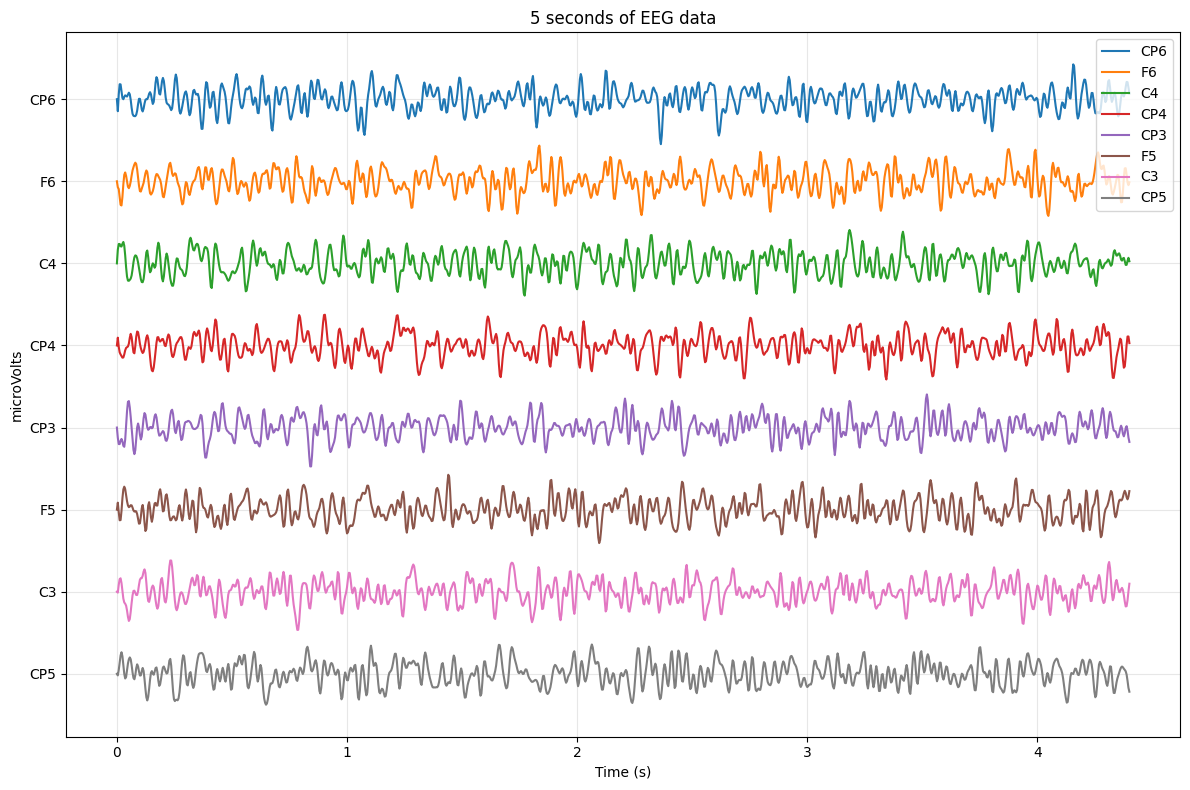

In [9]:
# Visualizing the 5 second window
n_channels, n_samples = data.shape
time = np.arange(n_samples) / 250  # assume 250 Hz sampling rate (adjust!)

plt.figure(figsize=(12, 8))

# Plot each channel with vertical offsets so they don’t overlap
offset = 100  # adjust spacing between signals
for i in range(n_channels):
    plt.plot(time, data[i] + i * offset, label=channels[i])

plt.yticks([i * offset for i in range(n_channels)], channels)
plt.gca().invert_yaxis()

plt.title("5 seconds of EEG data")
plt.xlabel("Time (s)")
plt.ylabel("microVolts")
plt.legend(loc="upper right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

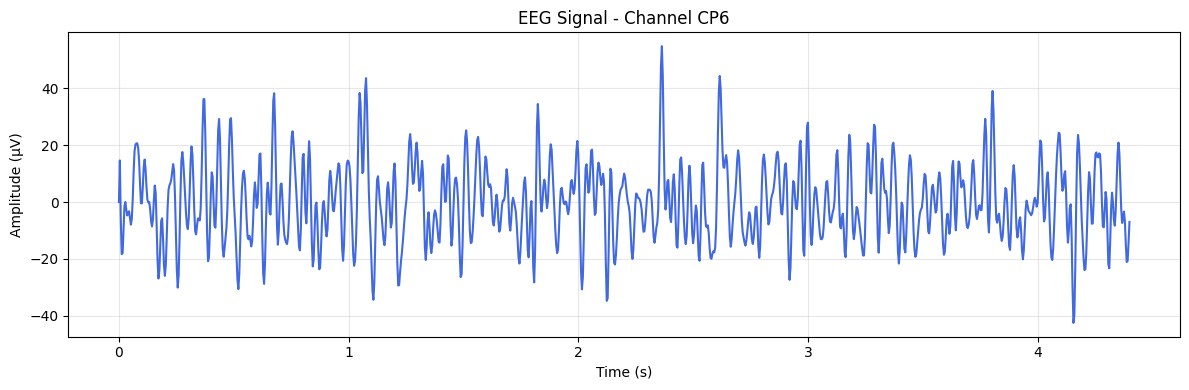

In [10]:
# Visualization for individual channels (e.g. "CP6")
channel_idx = channels.index("CP6")
channel_data = data[channel_idx]

# Sampling rate (adjust to your device)
fs = 250  
time = np.arange(channel_data.shape[0]) / fs

plt.figure(figsize=(12, 4))
plt.plot(time, channel_data, color="royalblue")
plt.title(f"EEG Signal - Channel {channels[channel_idx]}")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# Absolute Power

In [11]:
# Retrieve Absolute Power (AP) brainwaves
import time

ap_sample = None

def ap_callback(data):
    global ap_sample
    ap_sample = data
    print("Absolute Power Update:", data)

# To subscribe to absolute power stream
unsubscribe_ap = neurosity.brainwaves_power_by_band(ap_callback)

# Run for a few seconds
time.sleep(5)

# Stop the subscription
unsubscribe_ap()

print(f"Final Absolute Power Sample: {ap_sample}")

Absolute Power Update: {'data': {'alpha': [2.5159497075117354, 4.481763644173987, 6.367941278373383, 2.1148200967906345, 3.379689195279703, 2.756554167271286, 3.413380795390974, 4.420733921499924], 'beta': [3.1215392684089798, 2.6275670663520696, 3.316538957475285, 2.4377089854621903, 1.8096039185331299, 2.188907375337637, 2.7015499225813553, 2.6541222721787694], 'delta': [2.4252104926278335, 2.7858155316184035, 1.1839144710169949, 1.1325489280254708, 2.038642616840689, 2.765918420602879, 5.673264744238349, 5.553805728722942], 'gamma': [0.7429260284739051, 0.6113735605529194, 0.4804013775219945, 0.6565423843668996, 0.4429794423826805, 0.46458221889710255, 0.7568503083899605, 0.46452567781765364], 'theta': [2.6505579805669313, 3.304791528282642, 2.527210402529017, 1.6017351591606488, 3.2126721090520007, 3.4893968044320243, 5.3231500137072025, 5.63474673201997]}, 'label': 'powerByBand'}
Absolute Power Update: {'data': {'alpha': [2.65778431592195, 2.1971349694648987, 3.2225378595390666, 3

## Dictionary Structure
- there are 5 frequencies, and each contains an array of 8 elements for the 8 channels, showing the power in each channel

In [12]:

print(ap_sample['data'])


{'alpha': [5.093018573529747, 2.3762996270256505, 2.968416441175947, 2.595722970214204, 2.047034049216591, 4.778849762763922, 4.109939455304618, 4.838441587588107], 'beta': [1.8948976198853624, 2.0848933838792973, 2.072702474935213, 2.685658089616831, 2.0494976056928307, 2.0230516629764943, 1.8018504710996774, 3.5580352200669054], 'delta': [3.8528173623214155, 2.4766126521190674, 3.5552235885297554, 2.075758344528495, 3.5346855422121974, 2.3807683807267286, 0.7884513315897765, 1.3442142488736488], 'gamma': [0.7526855726931042, 0.572434760575478, 0.6276573799126445, 0.8392004659703248, 0.657833233100313, 0.5821749478862607, 0.5614211831268515, 0.6079527739123863], 'theta': [4.032683753013089, 3.780478520164703, 5.033147673203066, 1.7733016471447853, 2.5347372962345083, 3.0561879870963633, 1.306520088763728, 1.6259088399569896]}


# Calm/Focus Data

## Neurosity.calm() quick explanation:

neurosity.calm() streams a probability (0–1) that represents how calm the user is, based on EEG signals.

Difference from raw/absolute power:
Instead of giving you raw brainwave amplitudes (e.g. alpha, beta, gamma), it already applies Neurosity’s built-in model to estimate calmness.

A possible use case that we can use: 
We may define relaxed via low beta & high alpha, for example.

In [13]:
# Retrieve Focus/Calm Probability for 5 seconds
import time

def callback(data):
    print("Probability:", data)

# subscribing to focus and calm streams
focus_unsubscribe = neurosity.focus(callback)
calm_unsubscribe = neurosity.calm(callback)
# Run for a few seconds
time.sleep(5)

# Stop the subscription
focus_unsubscribe()
calm_unsubscribe()
print(f"Final Focus Sample: {sample}")

Probability: {'label': 'focus', 'metric': 'awareness', 'probability': 0.5282266136761394, 'timestamp': 1756302311924}
Probability: {'label': 'calm', 'metric': 'awareness', 'probability': 0.310704509881241, 'timestamp': 1756302312585}
Probability: {'label': 'focus', 'metric': 'awareness', 'probability': 0.4883942457235334, 'timestamp': 1756302313012}
Probability: {'label': 'calm', 'metric': 'awareness', 'probability': 0.3562120328475755, 'timestamp': 1756302313666}
Probability: {'label': 'focus', 'metric': 'awareness', 'probability': 0.5806065407250437, 'timestamp': 1756302314087}
Probability: {'label': 'calm', 'metric': 'awareness', 'probability': 0.3581988674952399, 'timestamp': 1756302314730}
Probability: {'label': 'focus', 'metric': 'awareness', 'probability': 0.4801013347698961, 'timestamp': 1756302315153}
Probability: {'label': 'calm', 'metric': 'awareness', 'probability': 0.4040039887470745, 'timestamp': 1756302315822}
Probability: {'label': 'focus', 'metric': 'awareness', 'proba

In [14]:
# Test out callback function for data retrieval
focusList = []
def callback_focus(data):
    global focusList
    focusList.append([data['timestamp'], {data['label']: data['probability']}])

f_unsubscribe = neurosity.focus(callback_focus)
time.sleep(3)
f_unsubscribe()

print(focusList)

[[1756302318475, {'focus': 0.5006428479048832}], [1756302319572, {'focus': 0.5669213915561057}], [1756302320661, {'focus': 0.5631357861567835}]]


## Accelerometer() explanation: 

Each epoch has three acceleration values: x, y and z. For example: 

In [ ]:
{
  "x": -0.02,
  "y": 0.99,
  "z": 0.07,
  "timestamp": 1635724527000
}


                                        
- The unit is expressed in g, where 1 g corresponds to the acceleration due to gravity on Earth.

- Values reflect both gravitational acceleration and any movement-induced acceleration.

- Accelerometer() focuses on movement, rather than specific brainwaves. 

##### By looking at accelerometer epochs, one can: 

- Detect when the user is moving.

- Flag those EEG segments as less reliable.

- Clean your dataset by removing or correcting for motion artifacts.
